## Nadaraya-Watson 核回归

In [151]:
import sys
sys.path.append('..')
import torch
from torch import nn
import d2l

生成数据集

$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$

In [152]:
n_train = 50 # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 排序后的训练样本

def f(x):
  return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,)) # 训练样本的输出
x_test = torch.arange(0, 5, 0.1) # 测试样本
y_truth = f(x_test) # 测试样本的真实输出
n_test = len(x_test) # 测试样本数
n_test

50

In [153]:
def plot_kernel_reg(y_hat):
  # 把测试集 预测数据（Pred） [x_test, y_hat]
  #         真实数据（Truth）[x_test, y_truth]
  # 画到坐标上   
  d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])
  # 绘制训练数据集散点图
  d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

平均池化

$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$

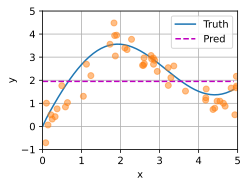

In [154]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

非参数注意力池化：

Nadaraya-Watson核回归：K是核

$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$

Nadaraya-Watson核回归 ---> 注意力池化（attention pooling）

$f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i,$

- $x$：查询
- $(x_i, y_i)$：键值对
- $\alpha(x, x_i)$：注意力权重（attention weight）

注意力池化 ---> 高斯核（Gaussian kernel）：$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).$

$$
\begin{split}\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}\end{split}
$$

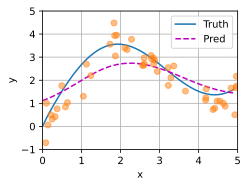

In [155]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

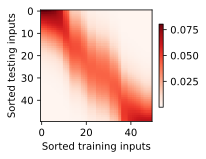

In [156]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

带参数注意力池化

$$
\begin{split}\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}\end{split}
$$

In [157]:
class NWKernelRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.w = nn.Parameter(torch.rand(1,), requires_grad=True)

  def forward(self, queries, keys, values):
    # queries和attention_weights的形状为(查询个数，“键－值”对个数)
    queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
    self.attention_weights = nn.functional.softmax(
      -((queries - keys) * self.w) ** 2 / 2, dim=1
    )
    # values的形状为(查询个数，“键－值”对个数)
    return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [158]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_title = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_title = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_title[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_title[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

In [159]:
keys.shape, values.shape

(torch.Size([50, 49]), torch.Size([50, 49]))

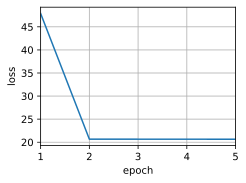

In [160]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
  trainer.zero_grad()
  l = loss(net(x_train, keys, values), y_train)
  l.sum().backward()
  trainer.step()
  print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
  animator.add(epoch + 1, float(l.sum()))

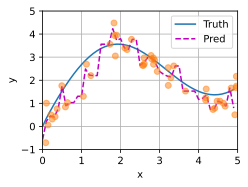

In [161]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

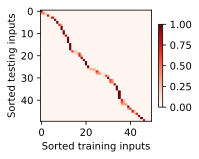

In [162]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')